In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('structured_dialogues.csv')
df.head()

,Movie Title,Year,Dialogue
0,Veer Zaara,2004,One early morning
1,Veer Zaara,2004,Lifting the dark misty veil
2,Veer Zaara,2004,of the night
3,Veer Zaara,2004,From its pillow of its mountain peak
4,Veer Zaara,2004,the Sun rose and saw...


In [3]:
print(df.isnull().sum())

Movie Title    0
Year           0
Dialogue       1
dtype: int64


In [4]:
df = df.fillna('-')
print(df.isnull().sum())

Movie Title    0
Year           0
Dialogue       0
dtype: int64


In [5]:
print(df.duplicated().sum())


10033


In [6]:
vz = df.copy()
vz.iloc[22945]

Movie Title    Chak De India
Year                    2007
Dialogue               Sorry
Name: 22945, dtype: object

In [7]:
df.tail()

,Movie Title,Year,Dialogue
123226,Animal,2023,Good.
123227,Animal,2023,You were the one singing while
123228,Animal,2023,"he was taking my brother's life, right?"
123229,Animal,2023,And you were the one who
123230,Animal,2023,handed him a knife at the runway.


In [8]:
df = df.groupby('Movie Title', group_keys=False).apply(lambda x: x.drop_duplicates(subset='Dialogue', keep='first'))
print(df.duplicated().sum())

0


C:\Users\Ashwin\AppData\Local\Temp\ipykernel_13112\1367022659.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Movie Title', group_keys=False).apply(lambda x: x.drop_duplicates(subset='Dialogue', keep='first'))


In [9]:
df_grouped = df.groupby(["Movie Title", "Year"])["Dialogue"].apply(" ".join).reset_index()

# Rename the column for clarity
df_grouped.rename(columns={"Dialogue": "Full Script"}, inplace=True)

print(df_grouped.head())

                  Movie Title  Year  \
0                    3 Idiots  2009   
1          Ae Dil Hai Mushkil  2016   
2                     Airlift  2016   
3  Ajab Prem Ki Ghazab Kahani  2009   
4                      Animal  2023   

                                         Full Script  
0  Hello Yes? What? Sir, kindly switch off your m...  
1  What's wrong with this city? Somewhere there a...  
2  And finally... How do you fit 30 Iraqis in one...  
3  <font color=fuchsia size=20> <i>Movie & Captio...  
4  POWER PROGRESS VICTORY 40th birthday, 50th bir...  


In [10]:
import re
import spacy
import en_core_web_sm

In [11]:
nlp = en_core_web_sm.load()


In [12]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"[^a-z\s]", "", text)  # Remove special characters and numbers
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]  # Lemmatization & stopword removal
    return " ".join(tokens)

In [13]:
df_grouped["Processed Script"] = df_grouped["Full Script"].apply(preprocess_text)

In [14]:
print(df_grouped.head())


                  Movie Title  Year  \
0                    3 Idiots  2009   
1          Ae Dil Hai Mushkil  2016   
2                     Airlift  2016   
3  Ajab Prem Ki Ghazab Kahani  2009   
4                      Animal  2023   

                                         Full Script  \
0  Hello Yes? What? Sir, kindly switch off your m...   
1  What's wrong with this city? Somewhere there a...   
2  And finally... How do you fit 30 Iraqis in one...   
3  <font color=fuchsia size=20> <i>Movie & Captio...   
4  POWER PROGRESS VICTORY 40th birthday, 50th bir...   

                                    Processed Script  
0  hello yes sir kindly switch mobile phone sec e...  
1  s wrong city ashe smoke not endure smoke quiet...  
2  finally fit   iraqis telephone booth tell belo...  
3  font colorfuchsia size imovie   captioning con...  
4  power progress victory th birthday th birthday...  


In [15]:
df_grouped.to_csv("processed_movie_scripts.csv", index=True)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
final_riz_df = pd.read_csv("processed_movie_scripts.csv")


In [18]:
misrepresentation_keywords = {
    "terrorism": [
        # Specific terms
        "jihad", "jihadist", "suicide bomber", "islamic terrorism", "terror cell", 
        "radical islam", "terror attack", "militant group", "holy war",
        # Broader violence-related terms (context needed)
        "bomb", "attack", "explosion", "martyr", "radical", "extremist", "militant"
    ],

    "anger": [
        # Specific behavioral cues
        "furiously shouted", "slapped", "punched", "violent temper", "uncontrollable rage",
        "abusive language", "violent outburst", "temper tantrum",
        # Broader emotional terms
        "rage", "furious", "angry", "short temper", "yelled", "screamed", "snapped", "exploded"
    ],

    "superstition": [
        # Specific references to religious extremism or magical thinking
        "divine punishment", "black magic", "evil eye", "curse", "ritual sacrifice",
        "holy blessing", "superstitious belief", "demonic possession",
        # Broader phrases
        "primitive tradition", "backward thinking", "religious law", "old ways", 
        "anti-modern", "ancient customs", "superstition", "orthodox", "ritual"
    ],

    "threat_to_western": [
        # Clear political/cultural conflict terms
        "anti-democracy", "death to the west", "sharia law", "dictatorship",
        "destroy freedom", "corrupt government", "overthrow system",
        # Criminal activity or anti-West tropes
        "gang activity", "underground network", "illegal trade", "contraband", 
        "arms dealer", "trafficking", "corruption", "fundamentalism"
    ],

    "misogyny": [
        # Specific oppression or violence
        "honor killing", "forced marriage", "child bride", "male authority", 
        "domestic abuse", "rape", "molestation", "harassment", "submission",
        # Phrases showing gendered power imbalance
        "serve her husband", "woman's duty", "women belong at home", "female obedience",
        "obedient wife", "women are weak", "man's world", "female servant", 
        "treats women like property", "prostitution", "used for pleasure"
    ]
}

In [19]:
# Initialize columns for each Riz Test feature
for category in misrepresentation_keywords:
    final_riz_df[category] = 0


In [20]:
# Use TF-IDF vectorization for keyword matching
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(final_riz_df["Processed Script"])


In [21]:
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())


In [22]:
# Check if any keyword is present in each script
for category, keywords in misrepresentation_keywords.items():
    # Filter out missing words that are not in the TF-IDF matrix
    existing_keywords = [word for word in keywords if word in tfidf_df.columns]
    
    if existing_keywords:  # Only proceed if at least one keyword exists in TF-IDF features
        final_riz_df[category] = tfidf_df[existing_keywords].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)
    else:
        final_riz_df[category] = 0  # If no keywords exist, set column to 0

In [23]:
# Compute final Riz Test Score (sum of all binary features)
final_riz_df["riz_score"] = final_riz_df[list(misrepresentation_keywords.keys())].sum(axis=1)

In [24]:
# Save updated dataframe
final_riz_df.drop(["Processed Script", "Full Script", "Unnamed: 0"], axis=1, inplace=True)
final_riz_df = final_riz_df.sort_values(by='Year', ascending=True)
final_riz_df.to_csv("riz_test_results.csv", index=False)

In [25]:
final_riz_df.head()

,Movie Title,Year,terrorism,anger,superstition,threat_to_western,misogyny,riz_score
15,Dhoom,2004,1,0,0,0,0,1
28,Main Hoon Na,2004,1,1,0,0,0,2
56,Veer Zaara,2004,0,1,1,0,0,2
29,Mangal Pandey,2005,1,1,1,1,0,4
41,Sarkar,2005,1,1,0,0,1,3


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

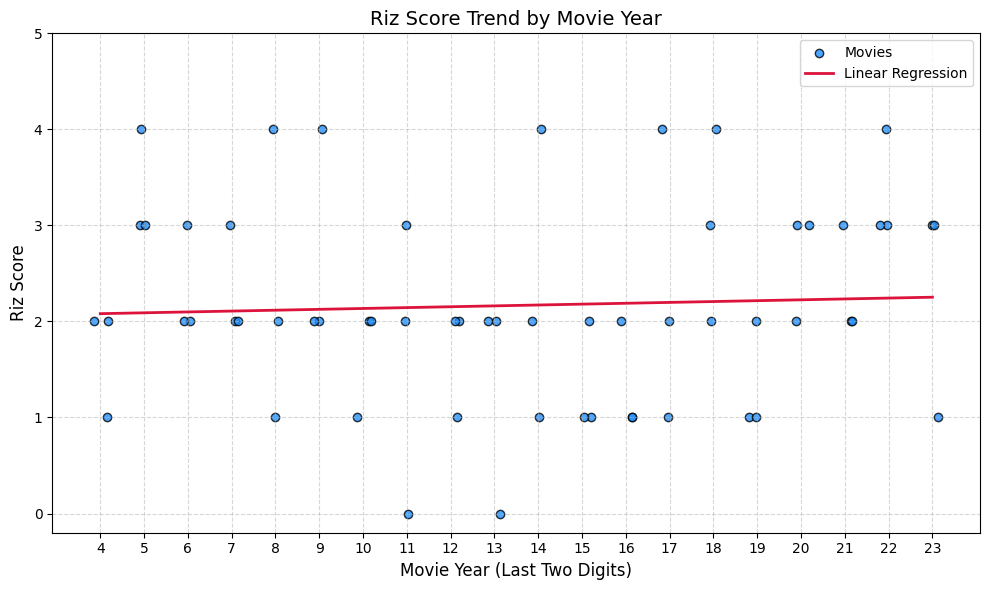

In [27]:
# Convert year to last two digits
final_riz_df["Year_short"] = final_riz_df["Year"] % 100  # e.g. 2004 → 4

# Prepare X (year) and y (riz_score) for regression
X = final_riz_df[["Year_short"]].values
y = final_riz_df["riz_score"].values

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10, 6))

# Jitter the X values for better visibility in scatter
x_jittered = X.flatten() + np.random.uniform(-0.2, 0.2, size=len(X))
plt.scatter(x_jittered, y, color="dodgerblue", alpha=0.8, edgecolors='k', label="Movies")

# Plot regression line
x_line = np.linspace(min(final_riz_df["Year_short"]), max(final_riz_df["Year_short"]), 100).reshape(-1, 1)
y_line = model.predict(x_line)
plt.plot(x_line, y_line, color="crimson", linewidth=2, label="Linear Regression")

# Labeling
plt.title("Riz Score Trend by Movie Year", fontsize=14)
plt.xlabel("Movie Year (Last Two Digits)", fontsize=12)
plt.ylabel("Riz Score", fontsize=12)
plt.yticks(range(0, 6))
plt.xticks(sorted(final_riz_df["Year_short"].unique()))
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()